In [47]:
import json
import random

import re
import string
import os.path
import timeit
from itertools import chain

import _pickle as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#Getting top 6 charaters based on utterances

characters = {}
total_utterences = 0

for i in range(1,11):
    # Each seasons file path
    f = open('json_data/friends_season_'+ str(i).zfill(2) +'.json', 'r')
    # Loading seaosns JSON
    season = json.loads(f.read())
    # Retrieve episodes
    episodes = season['episodes']
    # Iterate through the episodes
    for episode in episodes:
        # Retrieve scenes
        scenes = episode['scenes']
        # Iterate through the scenes
        for scene in scenes:
            # Retrieve utterances
            utterances = scene['utterances']
            # Iterate through the utterances
            for utterance in utterances:
                speaker = utterance['speakers']
                
                #not considering when multiple speakers are there as it's in less than 1% of cases.
                if len(speaker) == 1:
                    try:
                        #print('\n\nSpeaker:',speaker[0], "Utter_id:", utterance['utterance_id'], ":-")
                        
                        tokens = utterance['tokens']
                        speaker = utterance['speakers']
                        character_entities = utterance['character_entities']

                        total_utterences += 1
                        speaker = speaker[0]
                        characters[speaker] = characters.get(speaker, 0) + 1
                    
                    except:
                        continue

# We will use 6 characters who have spoken the most utterances and remaining will be considered in 'others' class
entities = [(i[0], i[1]) for i in sorted(characters.items(), key = lambda kv: kv[1], reverse=True)]

count_top6 = sum([elem[1] for elem in entities[:6]])
count_others = sum([elem[1] for elem in entities[6:]])

print("\ntotal_utterences: {0}, count_top6: {1}, count_others: {2}\n".format(total_utterences, count_top6, count_others))
assert total_utterences == count_top6 + count_others, "Count Mismatch!!!"

print("**A utterence may contain multiple sentences.")
print("\ntotal_utterences instances: {0} \ncount_top6: {1} \ncount_others: {2}\n".format(total_utterences, \
                                                                                  count_top6, count_others))
assert total_utterences == count_top6 + count_others, "Count Mismatch!!!"


#Taking only top6 and adding two more classes 'Others' and 'None'
entities = entities[:6] + [('Others', count_others), ('None', 0)]
entities_dict = {i[0]:i[1] for i in entities}

entities = [i[0] for i in entities]

for e in entities_dict:
    print(f'{e}: {entities_dict[e]}')



total_utterences: 24396, count_top6: 19817, count_others: 4579

**A utterence may contain multiple sentences.

total_utterences instances: 24396 
count_top6: 19817 
count_others: 4579

Ross Geller: 3820
Rachel Green: 3553
Chandler Bing: 3377
Monica Geller: 3328
Joey Tribbiani: 2907
Phoebe Buffay: 2832
Others: 4579
None: 0


In [10]:
#Token generation

cnt_None = 0
data = []
labels = []        

start = timeit.default_timer()

# Sepearte out data and labels
for i in range(1,11):
    # Each seasons file path
    f = open('json_data/friends_season_'+ str(i).zfill(2) +'.json', 'r')
    # Loading seaosns JSON
    season = json.loads(f.read())
    # Retrieve episodes
    episodes = season['episodes']
    # Iterate through the episodes
    for episode in episodes:
        # Retrieve scenes
        scenes = episode['scenes']
        # Iterate through the scenes
        for scene in scenes:
            # Retrieve utterances
            utterances = scene['utterances']
            # Iterate through the utterances
            for utterance in utterances:
                speaker = utterance['speakers']
                
                if len(speaker) == 1:
                    try:
                        #print('\n\nSpeaker:',speaker[0], "Utter_id:", utterance['utterance_id'], ":-")
                        
                        tokens = utterance['tokens']
                        speaker = utterance['speakers']
                        character_entities = utterance['character_entities']

                        #coz tokens is list of list where each list represents a sentence.
                        for i in range(len(tokens)):
                          
                            #print("\n",tokens[i])
                            
                            #we associate "None" label to each token in character_entities
                            target = ['None'] * len(tokens[i])
                            cnt_None += len(target)
                            
                            
                            """
                                "character_entities": [
                                            [],
                                            [[0, 1, "Paul the Wine Guy"], [4, 5, "Paul the Wine Guy"], [5, 6, "Monica Geller"]]
                                ]
                            """
                            
                            #change target labels if character_entities[i] has some entries
                            if character_entities[i]:
                                for e in character_entities[i]:
                                    
                                    #start and end index for label
                                    indexes = list(range(e[0], e[1]))
                                    for j in indexes:
                                        if e[2] in entities_dict:
                                            target[j] = e[2]
                                        else:
                                            target[j] = 'Others'
                                        
                                        #subtracting None count as they are replaced
                                        cnt_None -= 1
                                        
                                    
                                # Insert data
                                if speaker[0] in entities:
                                    data.append({'speaker': speaker[0], 'tokens': tokens[i]})
                                    labels.append(target)
                                else:
                                    data.append({'speaker': 'Others', 'tokens': tokens[i]})
                                    labels.append(target)

                                #print("\nT:",data[-1])
                                #print("L:",target)
                            
                            
                    except:
                        continue


print("\nTime to generate tokens: %.4f seconds.\n" % (timeit.default_timer() - start))

print("\nTotal sentences spoken:", len(data))
assert len(data) == len(labels), "***Size Mismatch!!!***"


print("\nFollowing shows count of utterences (an utterence may contain multiple sentences) by top 6 entities and others.\
      \nHowever None shows count of tokens that doesn't refer to any entity (top6 or others).\
      \nNeed to change this to avoid confusion.")

#adding count of None classes
entities_dict['None'] = cnt_None
entities_dict




Time to generate tokens: 4.3352 seconds.


Total sentences spoken: 26402

Following shows count of utterences (an utterence may contain multiple sentences) by top 6 entities and others.      
However None shows count of tokens that doesn't refer to any entity (top6 or others).      
Need to change this to avoid confusion.


{'Ross Geller': 3820,
 'Rachel Green': 3553,
 'Chandler Bing': 3377,
 'Monica Geller': 3328,
 'Joey Tribbiani': 2907,
 'Phoebe Buffay': 2832,
 'Others': 4579,
 'None': 288967}

In [37]:
print(data[0]) 
print(labels[0]) 


print("")

print(data[2]) 
print(labels[2])

print("")

print(data[-1]) 
print(labels[-1])


{'speaker': 'Monica Geller', 'tokens': ['He', "'s", 'just', 'some', 'guy', 'I', 'work', 'with', '!']}
['Others', 'None', 'None', 'None', 'Others', 'Monica Geller', 'None', 'None', 'None']

{'speaker': 'Joey Tribbiani', 'tokens': ['There', "'s", 'got', 'ta', 'be', 'something', 'wrong', 'with', 'him', '!']}
['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'Others', 'None']

{'speaker': 'Chandler Bing', 'tokens': ['I', "'m", 'still', 'on', 'London', 'time', ',', 'does', 'that', 'count', '?']}
['Chandler Bing', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']


In [13]:
# count of each label
pd.Series(list(chain.from_iterable(labels))).value_counts()

None              228134
Others             20937
Ross Geller         7652
Rachel Green        5454
Chandler Bing       4815
Joey Tribbiani      4685
Monica Geller       4099
Phoebe Buffay       4069
dtype: int64

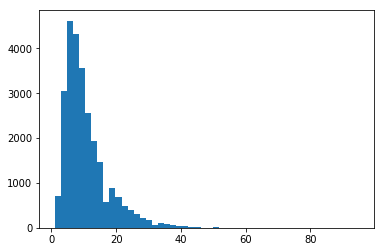

mean length: 10.599386410120445
meadian length: 9.0 

6     2397
7     2226
5     2220
8     2088
4     1997
9     1839
10    1731
11    1384
12    1176
3     1060
13    1046
14     889
15     786
2      716
16     673
17     568
18     485
19     405
20     365
21     311
22     281
23     203
25     199
24     193
26     189
28     116
27     114
29     107
30      89
31      77
      ... 
38      27
40      22
39      19
41      19
43      16
42      12
44      12
45      12
46       6
51       5
49       4
55       4
50       4
56       3
1        3
47       3
57       2
58       2
54       2
48       1
64       1
61       1
59       1
65       1
76       1
91       1
53       1
52       1
84       1
95       1
Length: 66, dtype: int64


In [32]:
# length of each sentence

plt.hist([len(r['tokens']) for r in data], bins=50)
plt.show()

print("mean length:",pd.Series([len(r['tokens']) for r in data]).mean())
print("meadian length:", pd.Series([len(r['tokens']) for r in data]).median(), "\n")
print(pd.Series([len(r['tokens']) for r in data]).value_counts())

In [48]:
# saving data 
dictionary = {"data": data,
              "labels": labels
             }

output = open("dataV3/data_dump.txt", "wb")
pickle.dump(dictionary, output)
output.close()


In [5]:

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

#25 dimensional word embeddings

start = timeit.default_timer()

#If glove embeds is not in word2vec form then first convert it then load it
if os.path.isfile('pretrained_embeds/gensim_glove_vectors.txt'):
    glove_model = KeyedVectors.load_word2vec_format("pretrained_embeds/gensim_glove_vectors.txt", binary=False)
    print("Embedding present...")
    print("Time to load: %.4f seconds." % (timeit.default_timer() - start))

    
else:
    glove2word2vec(glove_input_file="pretrained_embeds/glove.twitter.27B.25d.txt", word2vec_output_file="pretrained_embeds/gensim_glove_vectors.txt")
    glove_model = KeyedVectors.load_word2vec_format("pretrained_embeds/gensim_glove_vectors.txt", binary=False)
    print("Time to build and load Word2Vec embeddings from Glove: %.4f seconds." % (timeit.default_timer() - start))

    
def get_embed(word):
    # Case folding
    word = word.lower()
    try:
        return (glove_model.get_vector(word))
    except:
        return (glove_model.get_vector('unk'))


C:\Anaconda5.2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Embedding present...
Time to load: 58.7485 seconds.


In [9]:

#shuffling the data 
temp = list(zip(data, labels))
random.shuffle(temp)
data, labels = zip(*temp)

data_embedding = []
label_index = []

#getting utterance embeddings 
for d in data:
    temp = []
    
    # Getting embeddings for tokens 
    for t in d['tokens']:
        temp.append(get_embed(t))
    temp = np.asarray(temp)
    
    #gettting embeddings for speakers (We are taking average of first name and last name embeddings)
    temp_speaker = []
    for s in d['speaker'].split():
        temp_speaker.append(get_embed(s))
    
    temp_speaker = np.asarray(temp_speaker)
    temp_speaker = np.mean(temp_speaker, axis=0).reshape(1,-1)
    
    #concatanating speaker embedding with utterance embeddings before the token embeddings
    temp = np.vstack((temp_speaker, temp))
    data_embedding.append(temp)
    
    
#getting label index from entities list
for label in labels:
    
    #appending a None to compensate for speaker added in embeddings
    label = ['None'] + label
    
    temp = []
    
    for l in label:
        temp.append(entities.index(l))
   
    temp = np.asarray(temp)
    label_index.append(temp)
    

print(len(data_embedding))
assert len(data_embedding) == len(label_index), "***Size Mismatch!!!***"


41681


In [16]:

TRAIN_SIZE = int(len(data_embedding)*0.8)

train_input = data_embedding[:TRAIN_SIZE]
train_label_index = label_index[:TRAIN_SIZE]

test_input = data_embedding[TRAIN_SIZE:]
test_label_index = label_index[TRAIN_SIZE:]

print("Training data len:", len(train_input))
assert len(train_input) == len(train_label_index), "***Size Mismatch!!!***"

print("Testing data len:", len(test_input))
assert len(test_input) == len(test_label_index), "***Size Mismatch!!!***"


Training data len: 33344
Testing data len: 8337


In [17]:

for i,e in enumerate(entities):
    print(i,e)

print('\n')
for i in range(10):
    print(data[i]["tokens"])
    
    #coz None is added in front to compensate for 
    print(train_label_index[i][1:], "\n")
    

0 Rachel Green
1 Ross Geller
2 Chandler Bing
3 Monica Geller
4 Joey Tribbiani
5 Phoebe Buffay
6 Others
7 None


['Dysprosium', '?']
[7 7] 

['But', 'I', 'wo', "n't", '.']
[7 5 7 7 7] 

['And', 'the', 'vet', 'said', 'it', 'was', 'time', '.']
[7 7 7 7 6 7 7 7] 

['Oh', 'yeah', ',', 'but', 'do', "n't", 'worry', '.']
[7 7 7 7 7 7 7 7] 

['I', 'know', '!']
[0 7 7] 

['Okay', '.']
[7 7] 

['Who', "'s", 'this', 'from', '?']
[7 7 7 7 7] 

['Oh', 'yeah', ',', 'of', 'course', 'you', 'do', "n't", '!']
[7 7 7 7 7 7 7 7 7] 

['So', 'you', 'did', "n't", 'leave', 'the', 'bank', '?']
[7 1 7 7 7 7 7 7] 

['I', "'m", 'sorry', '!']
[6 7 7 7] 



In [18]:
#saving data

data_path = 'dataV2/'

#np.save() saves in  platform independent format
#hot vector of entities labels
np.save(data_path + 'entities-vector.npy', entities)

#Train Input embeddings
np.save(data_path + 'train_input.npy', train_input)

#Test input embeddings 
np.save(data_path + 'test_input.npy', test_input)

#Train label indexes
np.save(data_path + 'train_label_index.npy', train_label_index)

#Train label indexes
np.save(data_path + 'test_label_index.npy', test_label_index)


#text version of above binary files
np.savetxt(data_path + 'entities-vector.txt', entities, fmt = "%s")

np.savetxt(data_path + 'train_input.txt', train_input, fmt = "%s")
np.savetxt(data_path + 'test_input.txt', test_input, "%s")

np.savetxt(data_path + 'train_label_index.txt', train_label_index, fmt = "%s" )
np.savetxt(data_path + 'test_label_index.txt', test_label_index, fmt = "%s")
